In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
import seaborn as sns
import sys
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install shutil

import os
from shutil import unpack_archive
pd.set_option("display.max_columns", 101)

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=6805a3fa806db61f664649889afe79d57a88922e616509e20571d106072f3439
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [ ]:
# Download dan extract dataset

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ" -O dataset.zip && rm -rf /tmp/cookies.txt

unpack_archive('dataset.zip', '')

os.remove('dataset.zip')

--2022-07-25 05:42:12--  https://docs.google.com/uc?export=download&confirm=t&id=1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ
Resolving docs.google.com (docs.google.com)... 108.177.121.101, 108.177.121.138, 108.177.121.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.121.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jf7lcdqj65beqm703hq2g1d5lmbu7ja1/1658727675000/11309364930090306574/*/1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ?e=download&uuid=819e0ba8-643a-412a-8d85-b689fa000b04 [following]
--2022-07-25 05:42:12--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jf7lcdqj65beqm703hq2g1d5lmbu7ja1/1658727675000/11309364930090306574/*/1b4DZIS7VfBI_V8-DbpsaCP0ij8u1K3hJ?e=download&uuid=819e0ba8-643a-412a-8d85-b689fa000b04
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 142.250.148.

### Explorasi Dataset

In [ ]:
# get label
label = os.listdir('train')
print(label)

['angry', 'fear', 'neutral', 'happy', 'surprise', 'sad', 'disgust']


In [ ]:
# Mencari jumlah setiap label
data_label = []
for nama_label in label:
    jumlah = len(os.listdir(os.path.join('train', nama_label)))
    detail_label = [nama_label, jumlah]
    data_label.append(detail_label)

print(data_label)

[['angry', 3993], ['fear', 4103], ['neutral', 4982], ['happy', 7164], ['surprise', 3205], ['sad', 4938], ['disgust', 436]]


In [ ]:
# Membuat dataframe jumlah label
df_label = pd.DataFrame(data_label)
df_label.columns = ['Ekspresi', 'Jumlah']
df_label

,Ekspresi,Jumlah
0,angry,3993
1,fear,4103
2,neutral,4982
3,happy,7164
4,surprise,3205
5,sad,4938
6,disgust,436


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


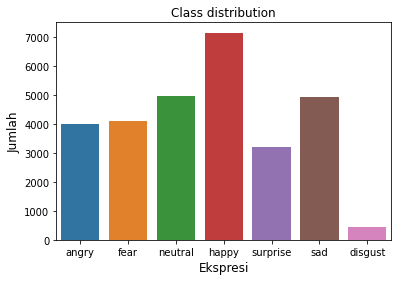

In [ ]:
# Membuat grafik jumlah label
plt.figure(figsize=(6,4))
sns.barplot(df_label.Ekspresi, df_label.Jumlah)
plt.title('Class distribution')
plt.ylabel('Jumlah', fontsize=12)
plt.xlabel('Ekspresi', fontsize=12)
plt.show()

In [ ]:
# Jumlah data training

jumlah_training = 0
jumlah_validation = 0 
for nama_label in label:
    jumlah_train = len(os.listdir(os.path.join('train', nama_label)))
    jumlah_val = len(os.listdir(os.path.join('validation', nama_label)))
    jumlah_training += jumlah_train
    jumlah_validation += jumlah_val

print('jumlah data training sebanyak', jumlah_training)
print('jumlah data validaiton sebanyak', jumlah_validation)

jumlah data training sebanyak 28821
jumlah data validaiton sebanyak 7066


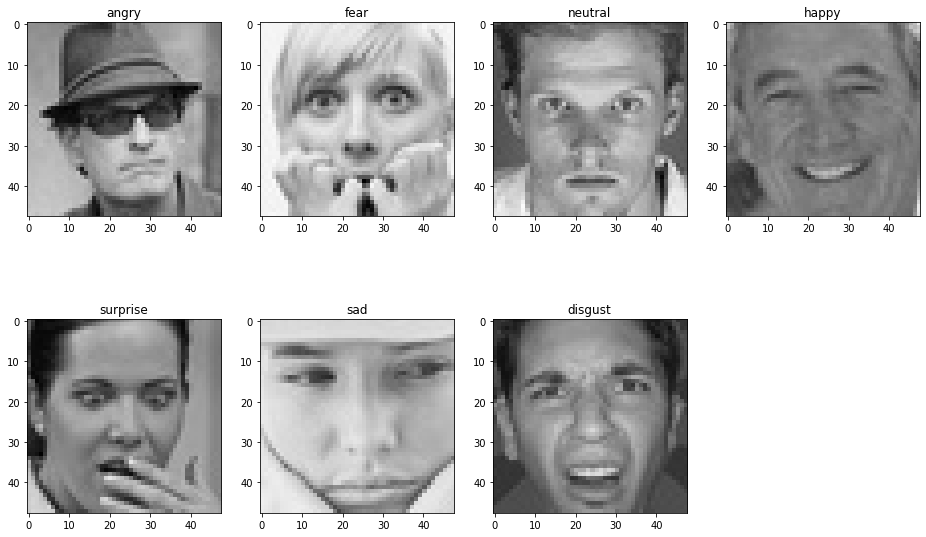

In [ ]:
# Membuat function untuk convert gambar ke array piksel
def gambarWajah(gambar, jenis_ekpresi, path):
    gambar_dir = os.path.join(path, jenis_ekpresi)
    gambar_path = os.path.join(gambar_dir, gambar)
    img = mpimg.imread(gambar_path)
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), jenis_ekpresi], dtype=object)

# Menampilkan contoh gambar
plt.figure(0, figsize=(16,10))
i = 1;
for nama_ekspresi in label:
    gambar_dir = os.path.join('train', nama_ekspresi)
    list_gambar_ekspresi = os.listdir(gambar_dir)
    nama_gambar = list_gambar_ekspresi[0]
    img = gambarWajah(nama_gambar, nama_ekspresi, 'train')
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])
    i+=1

plt.show()  

### Membuat Model Face Expression

In [ ]:
#initilize parameters
jumlah_epochs = 200
ukuran_batch = 64

In [ ]:
# Image Data Generator
train_datagen = ImageDataGenerator(
      rotation_range = 10,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      zoom_range = 0.1,
      horizontal_flip = True,
      fill_mode = 'nearest'
)
validation_datagen = ImageDataGenerator()

In [ ]:
# Preprocess Data Gambar

train_generator = train_datagen.flow_from_directory(
    "train/",
    target_size=(48,48),
    batch_size = ukuran_batch,
    color_mode = 'grayscale',
    class_mode = "categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    "validation/",
    target_size=(48,48),
    batch_size = ukuran_batch,
    color_mode = 'grayscale',
    class_mode = "categorical"
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
# Membuat arsitektur model Convolutional Neural Network
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(512, (3,3), input_shape=(48,48,1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Conv2D(512, (3,3), padding='same'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(64),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(32),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(7, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 512)       5120      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 512)      2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 512)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 512)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 512)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 512)       2

In [ ]:
# Compile model

model.compile(optimizer=Adam(lr=0.0001), loss="categorical_crossentropy", metrics = ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Fit model

history = model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs=jumlah_epochs, 
    steps_per_epoch = jumlah_training/ukuran_batch,
    validation_steps = jumlah_validation/ukuran_batch,
    verbose = 1,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
)

Epoch 1/200
450/450 [==============================] - 72s 121ms/step - loss: 2.0375 - accuracy: 0.2056 - val_loss: 1.7968 - val_accuracy: 0.2724
Epoch 2/200
450/450 [==============================] - 55s 121ms/step - loss: 1.8690 - accuracy: 0.2488 - val_loss: 1.6950 - val_accuracy: 0.3231
Epoch 3/200
450/450 [==============================] - 53s 117ms/step - loss: 1.7709 - accuracy: 0.2919 - val_loss: 1.6013 - val_accuracy: 0.3565
Epoch 4/200
450/450 [==============================] - 53s 118ms/step - loss: 1.6972 - accuracy: 0.3250 - val_loss: 1.6178 - val_accuracy: 0.3656
Epoch 5/200
450/450 [==============================] - 55s 121ms/step - loss: 1.6257 - accuracy: 0.3615 - val_loss: 1.4628 - val_accuracy: 0.4431
Epoch 6/200
450/450 [==============================] - 54s 120ms/step - loss: 1.5665 - accuracy: 0.3927 - val_loss: 1.4868 - val_accuracy: 0.4401
Epoch 7/200
450/450 [==============================] - 54s 121ms/step - loss: 1.5146 - accuracy: 0.4141 - val_loss: 1.4157 -

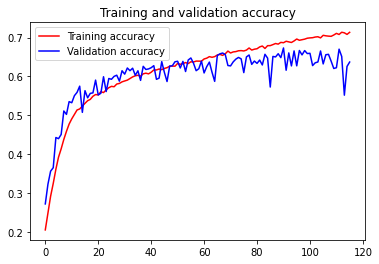

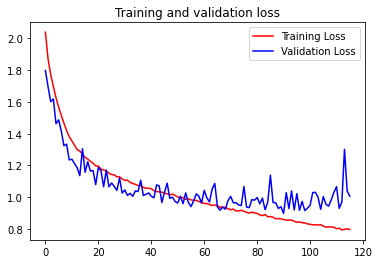

In [ ]:
# Plot akurasi training dan validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Confusion Matrix
Training Dataset

Confusion Matrix
[[ 745   39  420  857  720  741  471]
 [  70    3   42   84  100   93   44]
 [ 705   28  425  937  731  764  513]
 [1254   60  751 1542 1261 1404  892]
 [ 937   56  502 1039  889  956  603]
 [ 803   51  509 1100  924  934  617]
 [ 528   36  354  657  560  632  438]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.19      0.16      3993
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.10      0.12      4103
       happy       0.25      0.22      0.23      7164
     neutral       0.17      0.18      0.17      4982
         sad       0.17      0.19      0.18      4938
    surprise       0.12      0.14      0.13      3205

    accuracy                           0.17     28821
   macro avg       0.14      0.15      0.14     28821
weighted avg       0.17      0.17      0.17     28821



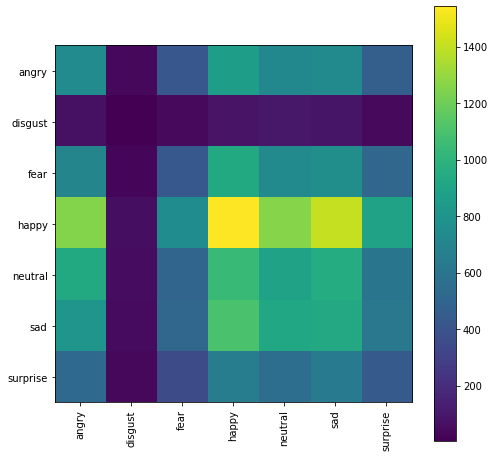

In [ ]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Validation Dataset

Confusion Matrix
[[192   4  77 199 205 157 126]
 [ 25   1  14  20  23  16  12]
 [208  12  76 211 225 166 120]
 [373  14 153 377 413 292 203]
 [233   7 102 275 258 207 134]
 [229   5  99 259 230 195 122]
 [152   6  74 175 156 127 107]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.20      0.16       960
     disgust       0.02      0.01      0.01       111
        fear       0.13      0.07      0.09      1018
       happy       0.25      0.21      0.23      1825
     neutral       0.17      0.21      0.19      1216
         sad       0.17      0.17      0.17      1139
    surprise       0.13      0.13      0.13       797

    accuracy                           0.17      7066
   macro avg       0.14      0.14      0.14      7066
weighted avg       0.17      0.17      0.17      7066



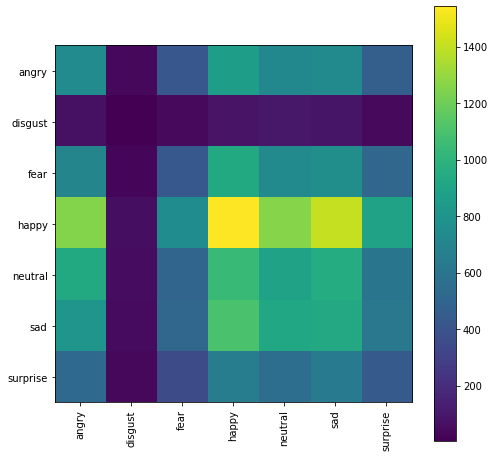

In [ ]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
cm_val = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_val)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Prediction

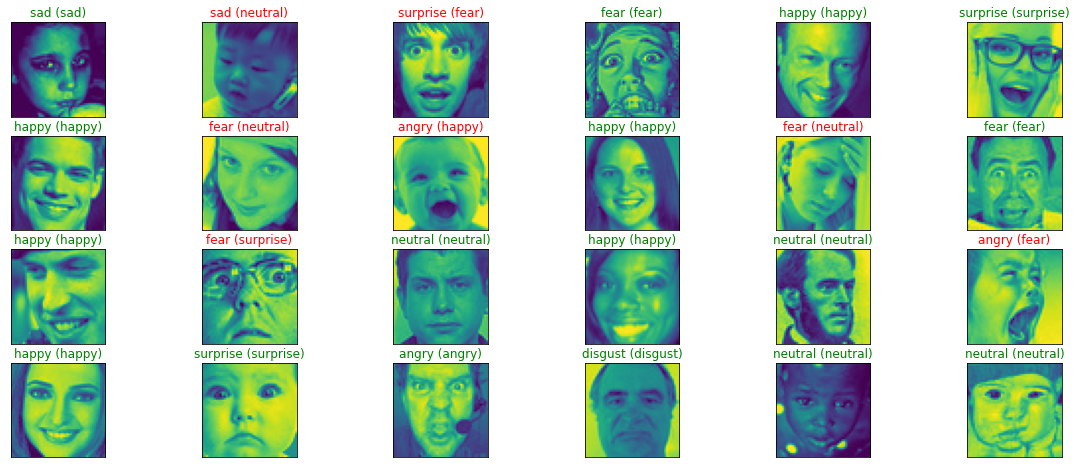

In [ ]:
x_test,y_test = next(validation_generator)
predict = model.predict(x_test)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))